# ARVATO CUSTOMER SEGMENTATION REPORT

Arvato Financial Solutions provides advanced analytics consulting services to brands and businesses. One of Arvato's clients is a mail order company in Germany looking to expand its customer base by launching a marketing campaign. The mailout order company requires a way to specifically target the subpopulation of Germany that is most likely to show interest.

The goal of this project is to develop a model that predicts if a person in the general population will be responsive to the company's marketing campaign and become a customer. The objective of this project is two-fold:

- Perform customer segmentation in order to identify parts of population that best describe core customer base of the company.
- Use analysis from customer segmentation to develop a predictive model to identify which individuals in the general population are potential customers.

Results of this project will help the mail-order company to target only potential customers within the general population which will reduce costs and increase the overall marketing efficiency.

Four sets of demographics data are provided by Arvato Financial Solutions. These datasets are explored in the next section.

In [1]:
# Import data analytics libraries
import numpy as np
import pandas as pd

# Import data visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# Import machine learning libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve


# Other imports
import re
from functools import reduce
from collections import defaultdict

# Silence IPython warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import datasets into workspace
azdias = pd.read_csv('data/azdias.zip', sep=';')
customers = pd.read_csv('data/customers.zip', sep=';')
mailout_train = pd.read_csv('data/mailout_train.zip', sep=';')
mailout_test = pd.read_csv('data/mailout_test.zip', sep=';')

del azdias['Unnamed: 0']
del customers['Unnamed: 0']
del mailout_train['Unnamed: 0']
del mailout_test['Unnamed: 0']

# Exploratory Data Analysis

## Data Overview

In [3]:
# Get overview of population data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,242311,2,1.0,10.0,NaN,NaN,NaN,NaN,9.0,NaN,...,NaN,1.0,1.0,1.0,0.0,9.0,NaN,3,1,4
1,258403,3,1.0,19.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,3.0,5.0,4.0,4.0,9.0,1.0,2,2,2
2,456053,-1,9.0,17.0,17.0,NaN,NaN,NaN,17.0,9.0,...,3.0,9.0,8.0,5.0,1.0,9.0,3.0,4,1,4
3,657368,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,8.0,...,2.0,10.0,13.0,10.0,6.0,9.0,4.0,4,2,1
4,1010951,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,8.0,...,2.0,3.0,5.0,3.0,2.0,6.0,2.0,3,1,4


In [4]:
# Get overview of customers data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
# Get overview of mailout train data
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [6]:
# Get Overview of mailout test data
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [7]:
# Visualize dataset sizes
datasets = ['azdias','customers','mailout_train','mailout_test']
dataset_sizes_1 = [azdias.shape[0], customers.shape[0], mailout_train.shape[0], mailout_test.shape[0]]
dataset_sizes_2 = [azdias.shape[1], customers.shape[1], mailout_train.shape[1], mailout_test.shape[1]]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Bar(x=datasets, y=dataset_sizes_1),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x = datasets, y = dataset_sizes_2),
    row=1, col=2
)

fig.update_xaxes(title_text="Dataset", row=1, col=1)
fig.update_xaxes(title_text="Dataset", row=1, col=2)

fig.update_yaxes(title_text="Number of Unique Individuals", row=1, col=1)
fig.update_yaxes(title_text="Number of Features", range=(340,370), row=1, col=2)

fig.update_layout(height=500, width=750, title_text="Dataset Sizes", showlegend=False)

fig.show()

All 4 datasets contain the same base demographic features which are 365 in total. All datasets also contain an individual identifer column named 'LNR'. Compared to azdias, customers contains 3 additional non-demographic features named CUSTOMER_TYPE, PURCHASE_TYPE and ONLINE_PURCHASE. Compared to azdias, mailout_train containes 1 extra boolean feature named 'RESPONSE'.

## Data Types

We will be analyzing features of azdias since it contains all the base demographic features. Looking at azdias dataset sample, it is not clear which data type each feature belongs to because feature names are not descriptive. Arvato has provided feature descriptions for most demographic features which we will use to assign data types to features. The following dataframe is manually constructed to identify the correct data type for each demographic feature. Several features also contain nan indicators which will need to be replaced with nan (not a number) at all locations

In [8]:
# Get dtypes and null placeholder values for each feature
feature_info = pd.read_csv('data/feature_info_2.csv',usecols=['feature','type','nan_indicators', 'action'], index_col='feature')
feature_info.head(5)

,type,nan_indicators,action
feature,,,
AGER_TYP,nominal,[-1.0],NaN
AKT_DAT_KL,ordinal,NaN,NaN
ALTER_HH,ordinal,[0.0],NaN
ALTER_KIND1,numeric,NaN,corr
ALTER_KIND2,numeric,NaN,corr


In [ ]:
# Generate Bar plots for
def bar_plot(df, col, return_unique = True, to_sort=True):
    fig = plt.figure(figsize=(10,7))
    df[col].value_counts().sort_values(ascending=False).plot.bar()
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.title(col)
    plt.show()
    if return_unique:
        return sorted(df[col].unique().tolist()) if to_sort else df[col].unique().tolist()
bar_plot(azdias, 'ANZ_PERSONEN', return_unique=False)

## Summary Statistics

In [9]:
# Describe numerial data
num_feat = feature_info[feature_info.type=='numeric'].index.tolist()
azdias[num_feat].drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'ANZ_STATISTISCHE_HAUSHALTE'], axis=1).describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,VERDICHTUNGSRAUM
count,399291.000000,397377.000000,409063.000000,409063.000000,409063.000000,392895.000000,397181.000000
mean,8.299889,0.041170,0.153233,1.728286,0.004070,620.232477,4.587460
std,15.739286,0.331788,0.499397,1.161666,0.068192,340.115860,8.468581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,384.000000,0.000000
50%,4.000000,0.000000,0.000000,1.000000,0.000000,550.000000,1.000000
75%,9.000000,0.000000,0.000000,2.000000,0.000000,779.000000,5.000000
max,595.000000,23.000000,9.000000,45.000000,4.000000,2300.000000,45.000000


Summary statistcis for some numerical features are shown in the dataframe above. ANZ_HAUSHALTE_AKTIV has a mean of 8.287 and a median of 4. This means that 50% of the data has a value of or less than 4 while the average value lies further to the right possibly due to outliers. Distribution is right skewed. ANZ_HH_TITEL and ANZ_KINDER are very similar in that the distribution is right skewed. For these two features, it also seems that the distribution pivots at around 0 with outliers to the right. Next, we will construct box and whisker plots for  these three features to visualize the distribution. KBA13_ANZAHL_PKW is also shown for contrast.

In [ ]:
# Generate box and whiskers for numerical features
def normalize(dist):
    min_val = dist.min()
    max_val = dist.max()
    return dist.apply(lambda x: (x-min_val)/(max_val-min_val))

normalized_features = azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'KBA13_ANZAHL_PKW']].dropna().apply(normalize, axis=0).values

fig = go.Figure()
fig.add_trace(go.Box(y=normalized_features[:,0],name='ANZ_HAUSHALTE_AKTIV'))
fig.add_trace(go.Box(y=normalized_features[:,1],name='ANZ_HH_TITEL'))
fig.add_trace(go.Box(y=normalized_features[:,2],name='ANZ_KINDER'))
fig.add_trace(go.Box(y=normalized_features[:,3],name='KBA13_ANZAHL_PKW'))

fig.show()

ANZ_HAUSHALTE_AKTIV and ANZ_HH_TITEL are severely right skewed (skew > 10) as there are many strong outliers. ANZ_KINDER is pivoted at 0 but is less skewed due to a lower number of outliers. KBA13_ANZAHL_PKW is slightly skewed to the right. There are some outliers to the right and the data is relatively well pivoted at the median. Overall, we find that most numerical features are skewed.

## Correlation Analysis

In [10]:
# Find Correlations between numerical features
num_feat = feature_info[feature_info.type=='numeric'].index.tolist()
corr = azdias[num_feat].sample(frac=0.25, random_state=42).corr()

# Construct seaborn heatmap
fig = plt.figure(figsize=(12,9))
g = sns.heatmap(corr, vmin=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(12,9)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da

There is strong correlation among the four ALTER_KIND features. ANZ_STATISTISCHE_HAUSHALTE and ANZ_HAUSHALTE_AKTIV have very strong correlation

## Missing values

In [ ]:
# Check null values
null_values_1 = azdias.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False)[:20]
null_value_indx_1 = azdias.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False).index.tolist()[:20]

null_values_2 = customers.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False)[:20]
null_value_indx_2 = customers.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False).index.tolist()[:20]

null_values_3 = mailout_train.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False)[:20]
null_value_indx_3 = mailout_train.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False).index.tolist()[:20]

null_values_4 = mailout_test.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False)[:20]
null_value_indx_4 = mailout_test.drop('LNR', axis=1).isnull().mean().sort_values(ascending=False).index.tolist()[:20]


fig = make_subplots(rows=2, cols=2)

fig.add_trace(
    go.Bar(x=null_value_indx_1, y=null_values_1),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x =null_value_indx_2, y = null_values_2),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=null_value_indx_3, y=null_values_3),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x =null_value_indx_4, y = null_values_4),
    row=2, col=2
)


fig.update_xaxes(title_text="Azdias", row=1, col=1)
fig.update_xaxes(title_text="Customers", row=1, col=2)
fig.update_xaxes(title_text="Mailout_train", row=2, col=1)
fig.update_xaxes(title_text="Mailout_test", row=2, col=2)


fig.update_yaxes(title_text="Ratio of Missing Values", row=1, col=1)
fig.update_yaxes(title_text="Ratio of Missing Values", row=1, col=2)
fig.update_yaxes(title_text="Ratio of Missing Values", row=2, col=1)
fig.update_yaxes(title_text="Ratio of Missing Values", row=2, col=2)

fig.update_layout(height=1600, width=1000, showlegend=False)

fig.show()

We can see that ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4, EXTSEL992 and KK_KUNDENTYP have >30 % of their data missing across all 4 datasets. We will drop features with a large chunk of their data missing (> 30% NaN). For features with less than 30% of their data missing, we will use imputation for numerical features, multiple imputation for ordinal features and constant imputation for nominal features.

## Data Cleaning

In the cell below, we create 3 dictionaries to hold data types, nan_indicators and special actions for each demographics feature. We will reference these frequently in the clean_data function.

In [12]:
# Create a dictionary that maps datatypes to feature names
dtypes = defaultdict(list)
for feature, dtype in zip(feature_info.type.index.tolist(), feature_info.type.tolist()):
    dtypes[dtype].append(feature)
    
# Create a dictionary that maps feature names to nan_indicators
nans = defaultdict()
for feature, nan in zip(feature_info.nan_indicators.index.tolist(), feature_info.nan_indicators.tolist()):
    try:
        clean_indicators = [float(s) for s in re.findall('(?<=\[).+?(?=\])', nan)[0].split(', ')]
        nans[feature] = clean_indicators
    except:
        continue

# Create dictionary that maps special action to feature names
actions = defaultdict(list)
for feature, action in zip(feature_info.action.index.tolist(), feature_info.action.tolist()):
    actions[action].append(feature)

The data cleaning function performs the following operations IN ORDER on all 4 datasets:

- Drop duplicated rows
- Format corrupted columns
- Reorder numerical encodings for misordered features
- Drop unrelated categories in ordinal features
- Convert datetime feature values to standardized date categories
- Apply log function to skewed numerical features
- Drop numerical features with very high correlations to other features
- Replace null placeholders with NaN (not a number) in all features
- Drop features with > 30% of their data missing
- Drop rows with >25% of their data missing (only for customers and azdias)

In [13]:
def clean_data(df, train=False):
    
    # Create deep copy of dataframe
    df = df.copy(deep=True)
    
    
    # Keep track of dropped columns
    cols_to_drop = []
    
    
    # Remove duplicated rows (uniqueness checked with identifier column, 'LNR')
    df.drop_duplicates(subset=['LNR'], keep='first', inplace=True)
    
    
    # Remove identifier column
    cols_to_drop.append('LNR')
    df.drop('LNR', axis=1, inplace=True)
    
    
    # Format corrupted features
    for col in actions['format']:
        df[col][(df[col].str.startswith('X'))&(df[col].notnull())] = np.nan
        if col != 'CAMEO_DEU_2015':
            df[col] = df[col].astype(np.float)
            
    
    # Reorder numerical encodings for misordered ordinal features
    reorder_dict_1 = {0.0:8.0}
    reorder_dict_2 = {0.0:6.0}
    for col in actions['value']:
        if col != 'D19_SOZIALES':
            df.loc[:,col] = df[col].apply(lambda x: reorder_dict_1[x] if x in reorder_dict_1 else x)
        else:
            df.loc[:,col] = df[col].apply(lambda x: reorder_dict_2[x] if x in reorder_dict_2 else x)
            
    
    # Drop unrelated categories in ordinal features with otherwise related categories
    to_drop = 9.0
    for col in actions['drop']:
        df.loc[:,col] = df[col].apply(lambda x: np.nan if x==to_drop else x)
        
        
    # Correct order of misordered features
    reorder_dict = {8.0:7.0, 7.0:8.0}
    for col in actions['order']:
        df.loc[:,col] = df[col].apply(lambda x: reorder_dict[x] if x in reorder_dict else x)
    
        
    # Assign NaNs to NaN placeholders
    for col in df.columns:
        try:
            nan_indicators_raw = feature_info.loc[col,'nan_indicators']
            nan_indicators = [float(s) for s in re.findall('(?<=\[).+?(?=\])', nan_indicators_raw)[0].split(', ')]
            df.loc[:,col] = df[col].apply(lambda x: np.nan if x in nan_indicators else x)
        except:
            continue
    
    
    # Convert datetime features to a standard yearly format
    datetime_cols = actions['date']
    df.loc[:, ['GEBURTSJAHR', 'MIN_GEBAEUDEJAHR']] = df[['GEBURTSJAHR', 'MIN_GEBAEUDEJAHR','EINGEZOGENAM_HH_JAHR']].apply(lambda x: pd.to_datetime(x, format="%Y").dt.year)
    df.loc[:, 'EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d").year)
    min_year = int(df[datetime_cols].min().min())
    max_year = int(df[datetime_cols].max().max())
    df.loc[:,datetime_cols] = df[datetime_cols].apply(lambda x: pd.cut(x.get_values(), bins=range(min_year-5, max_year+5, 5)).codes)
    for col in datetime_cols:
        df.loc[:,col] = df[col].apply(lambda x: np.nan if x==-1.0 else x)
    
    
    # Apply log function to skewed numerical features
    num_cols = feature_info[feature_info.type=='numeric'].index.tolist()
    for col in num_cols:
        if abs(df[col].skew()) >= 1.5:
            df[col] = np.log(df[col]+1)
    
    
    # Drop numerical columns with high corelations (> 0.90) to other numerical columns
    num_cols = feature_info[feature_info.type=='numeric'].index.tolist()
    df_numerical = df[num_cols]
    corr_mat = df_numerical.corr(method='pearson').abs()
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    cols_to_drop.extend([column for column in upper.columns if any(upper[column] > 0.90)])
    df.drop([column for column in upper.columns if any(upper[column] > 0.90)], axis=1, inplace=True)

    
    # Drop columns with > 30% missing data
    for col in df.columns:
        if df[col].isnull().mean() >= 0.30:
            cols_to_drop.append(col)
            df.drop(col, axis=1, inplace=True)
            cols_to_drop.append(col)
    
    
    if not train:
        # Remove rows with > 25% NaN entries (only for non training purposes)
        df = df.dropna(thresh = int(0.75*df.shape[1])).reset_index(drop=True)
            
            
    return df,list(set(cols_to_drop))

In [16]:
# Apply data cleaning function on azdias sample
print('Cleaning azdias sample ...')
df_sample = azdias.sample(n=250_000, random_state=42).reset_index(drop=True)
df_cleaned_azdias, cols_to_drop_azdias = clean_data(df_sample)
print('Columns dropped: ', len(cols_to_drop_azdias))
print(cols_to_drop_azdias, '\n\n')

# Apply data cleaning function on customers sample
print('Cleaning customers sample ...')
df_sample = customers.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis=1)
df_cleaned_customers, cols_to_drop_customers = clean_data(df_sample)
print('Columns dropped: ', len(cols_to_drop_customers))
print(cols_to_drop_customers, '\n\n')

# Apply data cleaning function on mailout_train sample
print('Cleaning mailout_train sample ...')
df_sample = mailout_train.drop('RESPONSE', axis=1)
df_cleaned_mailout_train, cols_to_drop_mailout_train = clean_data(df_sample, train=True)
print('Columns dropped: ', len(cols_to_drop_mailout_train))
print(cols_to_drop_mailout_train, '\n\n')

# Apply data cleaning function on mailout_test sample
print('Cleaning mailout_test sample ...')
df_sample = mailout_test.copy(deep=True)
df_cleaned_mailout_test, cols_to_drop_mailout_test = clean_data(df_sample, train=True)
print('Columns dropped: ', len(cols_to_drop_mailout_test))
print(cols_to_drop_mailout_test, '\n\n')

# Find union of columns dropped
dropped_cols = reduce(np.union1d, (cols_to_drop_azdias, cols_to_drop_customers, cols_to_drop_mailout_test, cols_to_drop_mailout_train))
print('ALL COLUMNS DROPPED: \n')
print(dropped_cols)
print('\n\n')

azdias_union_diff = np.setdiff1d(dropped_cols, cols_to_drop_azdias, assume_unique=True).tolist()
customers_union_diff = np.setdiff1d(dropped_cols, cols_to_drop_customers, assume_unique=True).tolist()
mailout_train_union_diff = np.setdiff1d(dropped_cols, cols_to_drop_mailout_train, assume_unique=True).tolist()
mailout_test_union_diff = np.setdiff1d(dropped_cols, cols_to_drop_mailout_test, assume_unique=True).tolist()

df_cleaned_azdias.drop(azdias_union_diff, axis=1, inplace=True)
df_cleaned_customers.drop(customers_union_diff, axis=1, inplace=True)
df_cleaned_mailout_train.drop(mailout_train_union_diff, axis=1, inplace=True)
df_cleaned_mailout_test.drop(mailout_test_union_diff, axis=1, inplace=True)


print('Additional feature(s) dropped from azdias: ', azdias_union_diff)
print('Additional feature(s) dropped from customers: ', customers_union_diff)
print('Additional feature(s) dropped from mailout_train: ', mailout_train_union_diff)
print('Additional feature(s) dropped from mailout_test: ', mailout_test_union_diff)

Cleaning azdias sample ...
Columns dropped:  15
['ALTER_KIND3', 'TITEL_KZ', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'VHA', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'LNR', 'ALTER_HH', 'AGER_TYP', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'EXTSEL992', 'ANZ_STATISTISCHE_HAUSHALTE'] 


Cleaning customers sample ...
Columns dropped:  17
['ALTER_KIND3', 'TITEL_KZ', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'VHA', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'REGIOTYP', 'LNR', 'ALTER_HH', 'KKK', 'AGER_TYP', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'EXTSEL992', 'ANZ_STATISTISCHE_HAUSHALTE'] 


Cleaning mailout_train sample ...
Columns dropped:  14
['ALTER_KIND3', 'TITEL_KZ', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'VHA', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'LNR', 'ALTER_HH', 'AGER_TYP', 'ALTER_KIND4', 'EXTSEL992', 'ANZ_STATISTISCHE_HAUSHALTE'] 


Cleaning mailout_test sample ...
Columns dropped:  14
['ALTER_KIND3', 'TITEL_KZ', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'VHA', 'GEBURTSJAHR', 'KBA05_BAUMAX', '

In [17]:
# Get clean data
df_azdias = df_cleaned_azdias.reset_index(drop=True)
df_customers = df_cleaned_customers.reset_index(drop=True)
df_mailout_train = df_cleaned_mailout_train.copy(deep=True)
df_mailout_test = df_cleaned_mailout_test.copy(deep=True)

## Data Transformation

We have to perform some preliminary transformations on our clean data before we can apply PCA transformation:

**Numerical Data**
- Impute missing data with column median 
- Scale data using standard scaling

**Ordinal Data**
- Impute missing data using an iterative imputer
- Encode data using ordinal encoding (Encode categorical features as an integer array)

**Nominal Data**
- Impute missing data with the most frequent value in column
- Encode data using one-hot encoding (Encode categorical integer features as a one-hot numeric array)

We will make a pipeline to streamline these transformation processes

In [18]:
# Sepearte data into dtypes; ckeck if feature hasn't been dropped during data cleaning
numeric_features = [n for n in dtypes['numeric'] if n not in dropped_cols]
ordinal_features = [n for n in dtypes['ordinal'] if n not in dropped_cols]
nominal_features = [n for n in dtypes['nominal'] if n not in dropped_cols]
datetime_features= [n for n in dtypes['datetime'] if n not in dropped_cols]

# treat datetime data as ordinal (datetime categories were already encoded during data cleaning)
ordinal_features.extend(datetime_features)

# Find categories for all ordinal features
df = pd.concat([df_azdias, df_customers, df_mailout_train, df_mailout_test], axis=0, ignore_index=True)
ole = OrdinalEncoder()
ole.fit(df[ordinal_features].apply(lambda x: x.fillna(x.max())))
ole_cat = ole.categories_

# Find categories for all nominal features
ohe = OneHotEncoder()
ohe.fit(df[nominal_features].apply(lambda x: x.fillna(x.value_counts().sort_values(ascending=False).index[0])))
ohe_cat = ohe.categories_


# Create custom feature selector for attribute selection in pipeline
class AttributeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns].values

    
# Create custom "iterative" imputer for ordinal features
class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.imputer = IterativeImputer(sample_posterior=False, max_iter=10, tol=0.001, n_nearest_features=20, initial_strategy="median", verbose=1)
        self.imputer.fit(X)
        return self
    def transform(self, X, y=None):
        imputed = np.around(self.imputer.transform(X))
        imp_t = imputed.T
        x_t = X.T
        for i,(imp,org) in enumerate(zip(imp_t,x_t)):
            diffs = np.setdiff1d(imp,org).tolist()
            diff_locs = []
            for diff in diffs:
                diff_locs.extend(np.where(imp==diff)[0].tolist())
            imputed[diff_locs,i] = np.median(org[~np.isnan(org)])
        return imputed
    
    
pipe_transform = Pipeline([
    
    ('features', FeatureUnion([
        
        ('numeric_pipeline', Pipeline([
            ('selector', AttributeSelector(numeric_features)),
            ('imputer', SimpleImputer(strategy='median')),
            ('std_scalar', StandardScaler())
            
        ])),
        
        ('ordinal_pipeline', Pipeline([
            ('selector', AttributeSelector(ordinal_features)),
            ('imputer', CustomImputer()),
            ('encoder', OrdinalEncoder(categories=ole_cat))
            
        ])),
        
        ('nominal_pipeline', Pipeline([
            ('selector', AttributeSelector(nominal_features)),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(categories = ohe_cat, sparse=False, n_values='auto'))
        ]))     
        
    ]))

])

pipe_transform.fit(df_azdias)

[IterativeImputer] Completing matrix with shape (220151, 307)
[IterativeImputer] Completing matrix with shape (220151, 307)


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  AttributeSelector(columns=['ANZ_HAUSHALTE_AKTIV',
                                                                                             'ANZ_HH_TITEL',
                                                                                             'ANZ_KINDER',
                                                                                             'ANZ_PERSONEN',
                                                                                             'ANZ_TITEL',
                                                                                             'KBA13_ANZAHL_PKW',
                            

# Customer Segmentation

We now have clean demographic data for the general population. We also have clean demographic data for customers of the mail-order company. The goal of this section is to identify parts of the population that best describe core customer base of the company. We will decompose demographics data to reduce dimensionality. Then, we will identify clusters in the general population. Clusters where customers are overrepresented as compared to the general population will have feature value/levels that are more indicative of customer interest.

In [19]:
# Transform azdias and customers data
df_azdias_transformed = pipe_transform.transform(df_azdias)
df_customers_transformed = pipe_transform.transform(df_customers)

[IterativeImputer] Completing matrix with shape (220151, 307)
[IterativeImputer] Completing matrix with shape (140354, 307)


## Principal Component Analysis

PCA is used to decompose a dataset with many (presumably) linearly dependent features into a set of linearly uncorrelated variables called principal components. With PCA, a complex dataset with many features can be represented in a much lower feature space. This transformation is defined in such a way that the first principal component accounts for most of original dataset's variability (it has the largest possible variance), and each succeeding component in turn has the highest variance with the condition that it be orthogonal to all preceding components.

In order to select the optimal number of principal components, we will plot total distortion against the number of components.

In [20]:
# Apply PCA to transformed azdias dataset
pca = PCA(random_state=42)
pca.fit(df_azdias_transformed)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

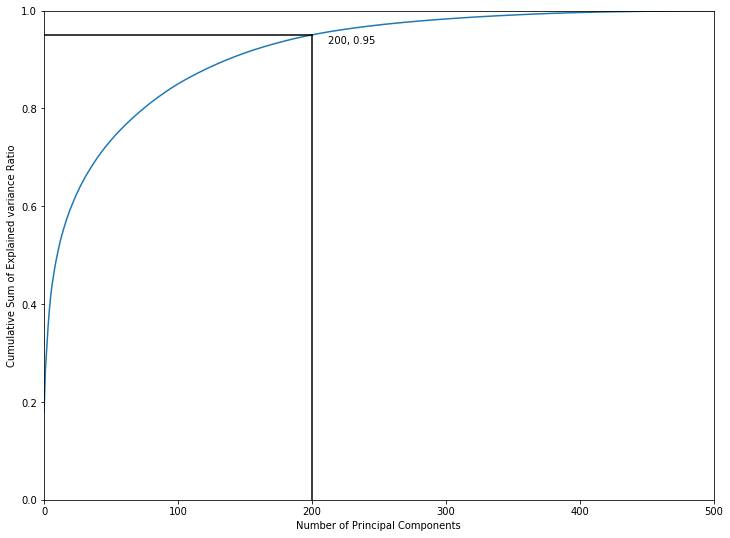

In [21]:
# Construct plot showing how much of the total varaince for transformed dataset is defined by the first k components
fig = plt.figure(figsize=(12,9))
cumsum = np.cumsum(pca.explained_variance_ratio_)
x_point = np.where(cumsum>=0.95)[0][0]
y_point = cumsum[x_point]
plt.plot(range(len(cumsum)), cumsum)
plt.plot((x_point,x_point), (0,y_point), color='k')
plt.plot((0,x_point), (y_point, y_point), color='k')
plt.annotate('{}, {:.2f}'.format(x_point, y_point), (x_point+12, y_point-0.017))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Sum of Explained variance Ratio')
plt.axis([0, 500, 0, 1.0])
plt.show()

The first 200 principal components define 95% of the total variance in our transformed dataset, so we select 200 principal components moving forward.

## K-Means Clustering

K-Means clustering is an unsupervised learning algorithm that partitions a data into a defined number of clusters. First, the algorithm identifes a number of centroids and then assigns each observation to the closest centroid. The algorithm tries to minimize the within-cluster sum of squares (distortion). The process is repeated over many ierations until the centroids have stabilized.

In [22]:
# Apply PCA with 200 components
pca = PCA(random_state=42, n_components=200)
df_azdias_pca = pca.fit_transform(df_azdias_transformed)

Distortion at N=1: 131109872.45282012
Distortion at N=2: 111398595.35684477
Distortion at N=3: 103989775.88133122
Distortion at N=4: 100857479.76147208
Distortion at N=5: 98403268.00061876
Distortion at N=6: 96495163.29181586
Distortion at N=7: 95381931.30222149
Distortion at N=8: 94324205.78306581
Distortion at N=9: 93380153.27023613
Distortion at N=10: 92371015.44682838
Distortion at N=11: 91646483.98061953
Distortion at N=12: 90858288.13506547
Distortion at N=13: 90240634.09453203
Distortion at N=14: 89760311.76864417
Distortion at N=15: 89234474.98524909
Distortion at N=16: 88726357.39918604
Distortion at N=17: 88340723.43333076
Distortion at N=18: 87885224.98472668
Distortion at N=19: 87533507.47225216
Distortion at N=20: 87056849.90956739
Distortion at N=21: 86643497.74801785
Distortion at N=22: 86305612.33631904
Distortion at N=23: 86027794.70763007
Distortion at N=24: 85625563.36333819
Distortion at N=25: 85299283.41185854
Distortion at N=26: 85029649.4681063
Distortion at N=27

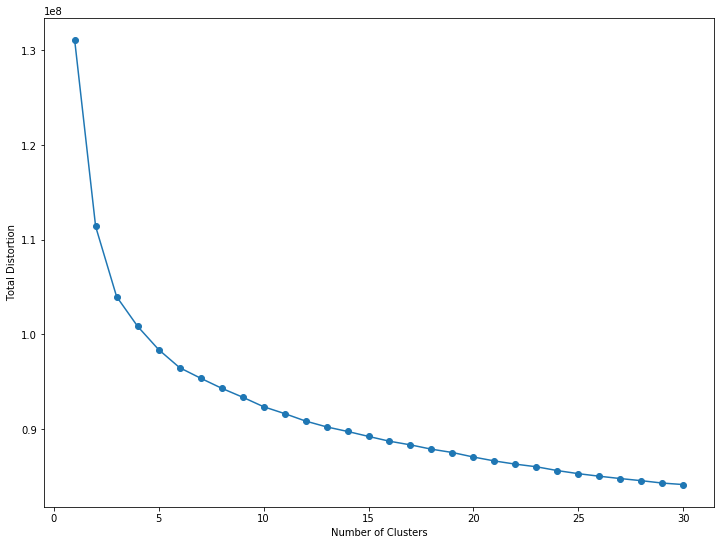

In [23]:
# Construct plot for total distortion versus number of clusters
distortions = []
x = []
for i in range(1,31):
    km = KMeans(n_clusters=i, init='k-means++',
               n_init=10, max_iter=30,
               tol=5e-02, random_state=42)
    km.fit(df_azdias_pca)
    inertia = km.inertia_
    distortions.append(inertia)
    x.append(i)
    print('Distortion at N={}: {}'.format(i, inertia))

fig = plt.figure(figsize=(12,9))
plt.plot(x, distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Total Distortion')
plt.show()

The plot above shows total distortion at different number of clusters. As we increase the number of clusters, distortion decreases. Notice that the graph appears to reach a local minima around N=14 before it breaks this pattern. The same pattern is located around N=17 although it is harder to notice. Repeated testing with random samples of the datasets show that the graph becomes linear after N=17 and the rate at which distortion decreases becomes samll. N=17 clusters is the optimal number of clusters for our K-Means algorithm.

In [24]:
# Apply PCA and K-means clustering

pipe_cluster = Pipeline([
    
    ('pca', PCA(random_state=42, n_components=200)),
    
    ('km', KMeans(n_clusters=17, init='k-means++', n_init=5, max_iter=5, tol=1e-01, random_state=42))

])

pipe_cluster.fit(df_azdias_transformed)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('km',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=5, n_clusters=17, n_init=5, n_jobs=None,
                        precompute_distances='auto', random_state=42, tol=0.1,
                        verbose=0))],
         verbose=False)

In [25]:
# Plot ratio of data in each cluster
azdias_labels = pipe_cluster.named_steps['km'].labels_
customers_labels = pipe_cluster.predict(df_customers_transformed)
unique_az, labels_az = np.unique(azdias_labels, return_counts=True)
azdias_counts = dict(zip(unique_az, labels_az/labels_az.sum()))

unique_cust, labels_cust = np.unique(customers_labels, return_counts=True)
customers_counts = dict(zip(unique_cust, labels_cust/labels_cust.sum()))

fig = go.Figure(data=[
    go.Bar(name='azdias', x=list(azdias_counts.keys()), y=list(azdias_counts.values())),
    go.Bar(name='customers', x=list(customers_counts.keys()), y=list(customers_counts.values()))
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

**NOTE: CLUSTERS WILL DIFFER WITH EACH NEW RUN OF THE NOTEBOOK**
The plot above shows the proportion of data contained in each cluster. We can see that the clustering has worked well since more than 45% of the customers data is in two clusters only: clusters 3 and 8. Customers are overrepresented in these clusters as compared to the general population. Conversely, customers are very underrepresented in cluster 4 and 16. Next, we find cluster centers for these 4 clusters in the original feature space.

## CLUSTER ANALYSIS

In order to understand which features are more important in being indicative of customer interest, we need to convert cluster centers to the original feature space

In [27]:
# Find cluster centers for clusters 7, 8 (over-represented) and 13, 11 (under-represented)
cluster_centers = pipe_cluster.named_steps['km'].cluster_centers_[[7,8,13,11]]

# Use PCA's inverse transform to map cluster centers back to the original feature space
cluster_centers_ofs = pipe_cluster.named_steps['pca'].inverse_transform(cluster_centers)

# Get all feature names
ohe_cat = pipe_transform.named_steps['features'].transformer_list[2][1].named_steps['encoder'].get_feature_names().tolist()
feature_names = numeric_features + ordinal_features + ohe_cat

# Make dataframe for cluster centers
cluster_centers_df = pd.DataFrame(np.abs(cluster_centers_ofs), columns=feature_names, index=[7,8,13,11])

# Convert ordinal data back to integer form
cluster_centers_df.loc[:,ordinal_features] = np.around(cluster_centers_df[ordinal_features])

# Show difference between the two
cluster_centers_diff = cluster_centers_df.loc[8,ordinal_features] - cluster_centers_df.loc[13,ordinal_features]
cluster_centers_diff2 = cluster_centers_df.loc[7,ordinal_features] - cluster_centers_df.loc[13,ordinal_features]
cluster_centers_diff3 = cluster_centers_df.loc[8,ordinal_features] - cluster_centers_df.loc[11,ordinal_features]
cluster_centers_diff4 = cluster_centers_df.loc[7,ordinal_features] - cluster_centers_df.loc[11,ordinal_features]
n_min = 3

important_features = cluster_centers_diff[(np.abs(cluster_centers_diff)>=n_min)&(np.abs(cluster_centers_diff2)>=n_min)&(np.abs(cluster_centers_diff3)>=n_min)&(np.abs(cluster_centers_diff4)>=n_min)].index

df_important = cluster_centers_df[important_features]

columns = [df_important.columns.tolist()]
columns.extend(df_important.values.tolist())

fig = go.Figure(data=[go.Table(header=dict(values=['FEATURES', 'OVERREP:7', 'OVERREP:8','UNDERREP:13', 'UNDERREP:11']),
                 cells=dict(values=columns))
                     ])
fig.show()

The table  above shows feature values for the four clusters for features in which feature values greatly differ between over- and under-respresented clusters. In the cells that follow, I will explain these differences.

In [28]:
def plot_bar(col):
    df = pd.concat([df_azdias[col].value_counts(), df_customers[col].value_counts()], axis=1)
    df.columns = ['azdias', 'customers']
    df.plot.bar(figsize=(10,7))
    plt.show()

CAMEO_INTL_2015 defines household wealth. A lower value denotes greater wealth and vice versa. Customers fall into the wealthy category whereas non-customers fall into the less affluent category. The bar plot of value counts in both datasets is shown below (12 is rich and 55 is poor). Notice that the distribution for customers is more to the left. This suggests that customers, on average, belong to wealthy households as compared to the average person in Germany.

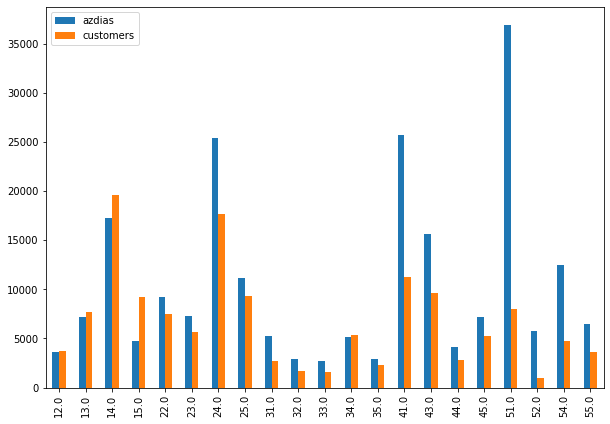

In [29]:
plot_bar('CAMEO_INTL_2015')

D19_GESAMT_DATUM defines purchasing activity. A lower value denotes very high purchasing activity and vice versa. Looking at feature values in the table above, we can see that most customers have a value of 5(cluster 8) and some have a value of 2 (cluster 3). These values correspond to 'very high purchasing activity in the last 12 months' and 'slightly increased activity in the last 12 months' respectively. In comparison, non-customers have a value of 8 which corresponds to 'most recent activity of older than 2 years'. Let's visualize this difference (bar plot below). The average value for customers seems to be around 5 while that for the general population is around 8. This suggests that customers, on average, have a higher purcahsing power as compared to the general population.

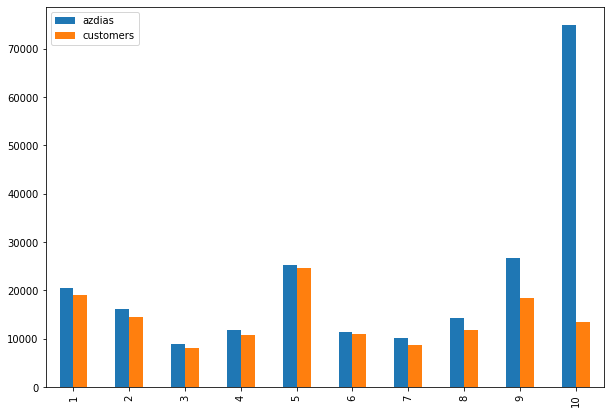

In [30]:
plot_bar('D19_GESAMT_DATUM')

HH_EINKOMMEN_SCORE is the estimated household net income. A lower value means greater net income and vice versa. The bar plot is shown below. Customers, on average, have a greater net income as comapred to the average person in the general population. In the bar plot below, customers are centered at a value of 3 while the general population is centered at around 5. This suggests that customers, on average, tend to have a higher net annual income.

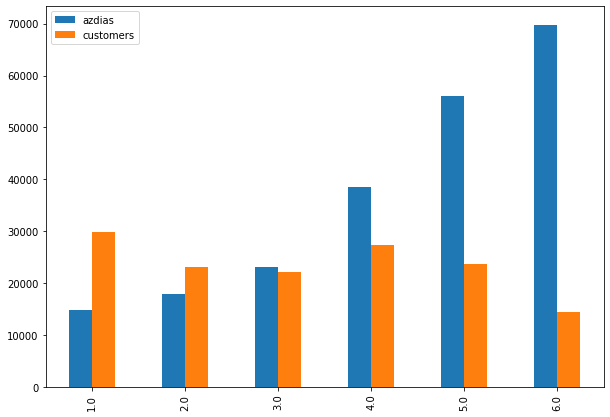

In [31]:
plot_bar('HH_EINKOMMEN_SCORE')

LP_FAMILIE_GROB is family type. Lower values denote individuals living alone or with a spouse; higher values define full and multigenerational families. The bar plot is shown below. The average value for customers is more towards the right. This suggests that customers, on average, belong to full families versus people in the general population who, on average live alone or with a spouse.

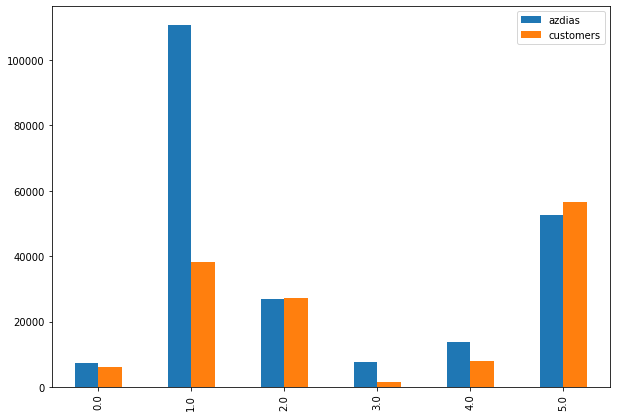

In [32]:
plot_bar('LP_FAMILIE_GROB')

LP_STATUS_GROB is social status. Lower values correspond to low-income earners. Higher values correspond to houseowners and top earners. From the table above, we can see that customers have higher incomes. This suggests that customers, on average, have have a higher social status than people in the general population.

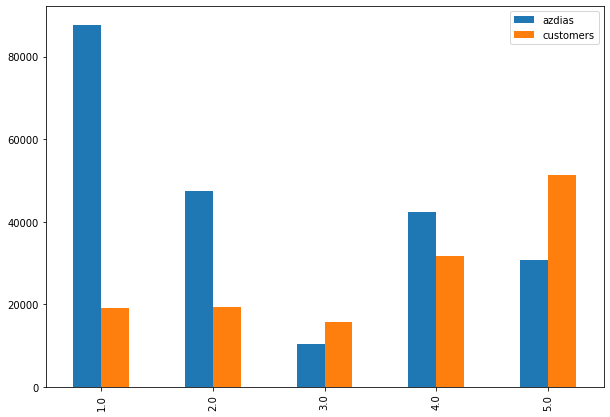

In [33]:
plot_bar('LP_STATUS_GROB')

MOBI_RASTER defines overall mobility. Lower values correspond to high mobility and vice versa. Clusters 3 and 8 (mostly customers) have middle mobility. Clusters 4 and 16 have a very high mobility (mostly non-customers). This suggests that customers, on average, have either a stable living place or a shorter commute time to jobs.

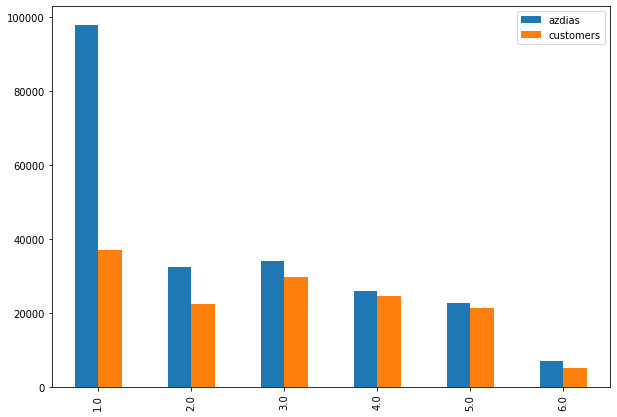

In [34]:
plot_bar('MOBI_RASTER')

# Predictive modeling

## Transformation

In [35]:
# Transform train and test sets
mailout_train_transformed = pipe_transform.transform(df_mailout_train)
mailout_test_transformed = pipe_transform.transform(df_mailout_test)

# Create X and y for training set
X = mailout_train_transformed
y = mailout_train.RESPONSE

# Apply PCA test sets
pca = pipe_cluster.named_steps['pca']
X_transformed = pca.transform(X)

# Resample train set using SMOTE
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_transformed, y)

[IterativeImputer] Completing matrix with shape (42962, 307)
[IterativeImputer] Completing matrix with shape (42833, 307)


## Classifiers


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


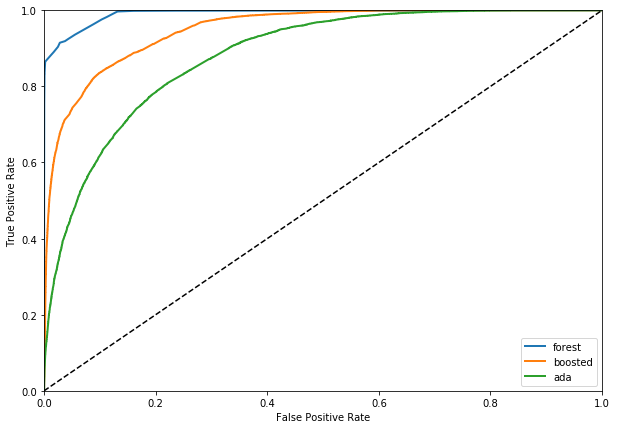

In [39]:
# Plot ROC curve
fig = plt.figure(figsize=(10,7))

# Initialize three ensemble tree classifiers
forest_clf = RandomForestClassifier(n_jobs=-1, verbose=1)
boosted_clf = GradientBoostingClassifier(verbose=1)
ada_clf = AdaBoostClassifier()

auc_scores = []
# Evaluate base form of each classifier
for clf,label in zip([forest_clf, boosted_clf, ada_clf], ['forest', 'boosted', 'ada']):
    learning_curve
    y_scores = cross_val_predict(clf, X_train, y_train, cv=3, method='predict_proba', verbose=2, n_jobs=-1)[:,1]
    auc_scores.append(roc_auc_score(y_train, y_scores))
    fpr, tpr, thresholds = roc_curve(y_train,y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=label)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## GridSearch

In [48]:
param_grid = {'n_estimators':[100,125,150], 'max_depth':[5,6], 'min_samples_split':[5,6], 'n_jobs':[-1]}
cv = GridSearchCV(forest_clf, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=3)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=5, min_samples_split=5, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.902, total=  14.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.5s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.904, total=  12.6s
[CV] max_depth=5, min_samples_split=5, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=5, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.904, total=  12.8s
[CV] max_depth=5, min_samples_split=5, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   15.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=5, n_estimators=125, n_jobs=-1, score=0.905, total=  16.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   16.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=5, n_estimators=125, n_jobs=-1, score=0.906, total=  17.3s
[CV] max_depth=5, min_samples_split=5, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=5, n_estimators=125, n_jobs=-1, score=0.904, total=  17.1s
[CV] max_depth=5, min_samples_split=5, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   19.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  max_depth=5, min_samples_split=5, n_estimators=150, n_jobs=-1, score=0.901, total=  20.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   18.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  max_depth=5, min_samples_split=5, n_estimators=150, n_jobs=-1, score=0.905, total=  19.4s
[CV] max_depth=5, min_samples_split=5, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  max_depth=5, min_samples_split=5, n_estimators=150, n_jobs=-1, score=0.905, total=  21.4s
[CV] max_depth=5, min_samples_split=6, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=100, n_jobs=-1, score=0.904, total=  12.8s
[CV] max_depth=5, min_samples_split=6, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=100, n_jobs=-1, score=0.907, total=  13.3s
[CV] max_depth=5, min_samples_split=6, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=100, n_jobs=-1, score=0.901, total=  13.2s
[CV] max_depth=5, min_samples_split=6, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   16.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=125, n_jobs=-1, score=0.902, total=  17.0s
[CV] max_depth=5, min_samples_split=6, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   15.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=125, n_jobs=-1, score=0.905, total=  16.2s
[CV] max_depth=5, min_samples_split=6, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   17.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=125, n_jobs=-1, score=0.898, total=  17.9s
[CV] max_depth=5, min_samples_split=6, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   18.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=150, n_jobs=-1, score=0.902, total=  19.1s
[CV] max_depth=5, min_samples_split=6, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   19.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=150, n_jobs=-1, score=0.908, total=  19.7s
[CV] max_depth=5, min_samples_split=6, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   19.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  max_depth=5, min_samples_split=6, n_estimators=150, n_jobs=-1, score=0.903, total=  19.9s
[CV] max_depth=6, min_samples_split=5, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.922, total=  15.3s
[CV] max_depth=6, min_samples_split=5, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.922, total=  15.5s
[CV] max_depth=6, min_samples_split=5, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.922, total=  15.3s
[CV] max_depth=6, min_samples_split=5, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   18.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=125, n_jobs=-1, score=0.922, total=  19.1s
[CV] max_depth=6, min_samples_split=5, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=125, n_jobs=-1, score=0.928, total=  21.0s
[CV] max_depth=6, min_samples_split=5, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=125, n_jobs=-1, score=0.926, total=  21.0s
[CV] max_depth=6, min_samples_split=5, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=150, n_jobs=-1, score=0.922, total=  22.9s
[CV] max_depth=6, min_samples_split=5, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=5, n_estimators=150, n_jobs=-1, score=0.928, total=  22.7s
[CV] max_depth=6, min_samples_split=5, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  max_depth=6, min_samples_split=5, n_estimators=150, n_jobs=-1, score=0.924, total=  23.2s
[CV] max_depth=6, min_samples_split=6, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=6, min_samples_split=6, n_estimators=100, n_jobs=-1, score=0.921, total=  15.0s
[CV] max_depth=6, min_samples_split=6, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=6, min_samples_split=6, n_estimators=100, n_jobs=-1, score=0.931, total=  15.4s
[CV] max_depth=6, min_samples_split=6, n_estimators=100, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV]  max_depth=6, min_samples_split=6, n_estimators=100, n_jobs=-1, score=0.922, total=  17.2s
[CV] max_depth=6, min_samples_split=6, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   22.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=6, n_estimators=125, n_jobs=-1, score=0.922, total=  23.3s
[CV] max_depth=6, min_samples_split=6, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  max_depth=6, min_samples_split=6, n_estimators=125, n_jobs=-1, score=0.928, total=  19.2s
[CV] max_depth=6, min_samples_split=6, n_estimators=125, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   19.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=6, n_estimators=125, n_jobs=-1, score=0.924, total=  20.2s
[CV] max_depth=6, min_samples_split=6, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  max_depth=6, min_samples_split=6, n_estimators=150, n_jobs=-1, score=0.923, total=  22.4s
[CV] max_depth=6, min_samples_split=6, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  max_depth=6, min_samples_split=6, n_estimators=150, n_jobs=-1, score=0.927, total=  22.4s
[CV] max_depth=6, min_samples_split=6, n_estimators=150, n_jobs=-1 ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   23.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.9min finished


[CV]  max_depth=6, min_samples_split=6, n_estimators=150, n_jobs=-1, score=0.922, total=  24.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   27.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=1,
                                              warm_start=False),
             iid='

## Model Performance

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.8s finished


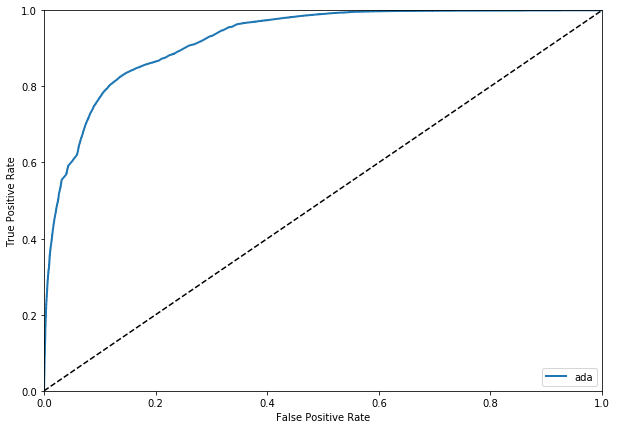

In [62]:
# Initialize classifier with the best parameters
fig = plt.figure(figsize=(10,7))
forest_clf = RandomForestClassifier(n_estimators=125, max_depth=6, min_samples_split=5, verbose=1, n_jobs=-1)
y_scores = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba', verbose=2, n_jobs=-1)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,y_scores)
plt.plot(fpr, tpr, linewidth=2, label=label)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Applying to test set

In [60]:
y_predict = cv.predict_proba(pca.transform(mailout_test_transformed))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


In [61]:
# Save to file
LNR = mailout_test.LNR.values
df = pd.DataFrame({'LNR':LNR.tolist(), 'RESPONSE':y_predict[:,1].tolist()})
df.to_csv('data/kaggle.csv')